In [31]:
import torch
import numpy as np
from pathlib import Path
from skimage import io
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio
import matplotlib.pyplot as plt
from loguru import logger

In [32]:
try:
    import google.colab
    drive.mount('/content/drive/', force_remount=True)

    !git clone https: // github.com/daria-yermakova/super_resolution.git
    !pip install loguru
    %cd super_resolution
except:
    logger.info("Running locally")

2023-04-26 23:23:09.611 | INFO     | __main__:<module>:9 - Running locally


In [3]:
%%bash
(source_file="/content/drive/My Drive/advanced_image_analysis/super_resolution/data_ps512_str4.zip"
dest_dir="./data"
if [ -d "$dest_dir" ]; then
  echo "Data already exists, skipping copy"
else
  cp "$source_file" .
  mkdir $dest_dir
  unzip -q -d ./data data_ps512_str4.zip
  echo "Data copied and unzipped successfully"
fi)


Data already exists, skipping copy


In [4]:
from image_preprocessing import preprocess

PATCH_SIZE = 512
STRIDE = 4
# only for re-preprocessing the imagery (patch, crop, upsample)
INPUT_DIR = "/content/drive/My Drive/advanced_image_analysis/super_resolution/test"
OUTPUT_DIR = "./data/"

run_preprocessing = False

In [5]:
!ls "{OUTPUT_DIR}patches_512" | wc -l

    1920


In [6]:
if run_preprocessing:
    preprocess(
        patch_size=PATCH_SIZE,
        stride=STRIDE,
        input_dir=INPUT_DIR,
        output_dir=OUTPUT_DIR,
    )


In [7]:
from config import PATCHES_TEMPLATE, CROPPED_TEMPLATE

patches_dir = Path(PATCHES_TEMPLATE.format(PATCH_SIZE))
cropped_dir = Path(CROPPED_TEMPLATE.format(PATCH_SIZE, STRIDE))

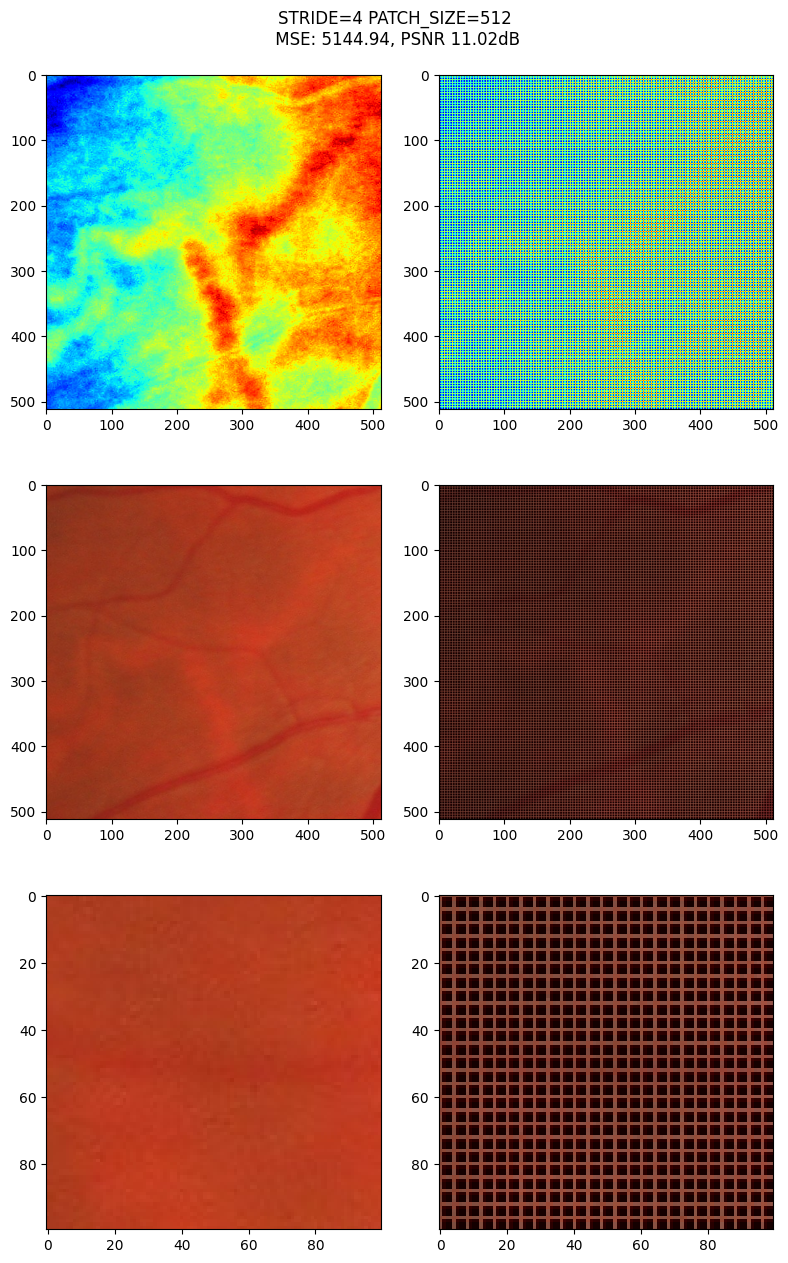

In [9]:
from image_preprocessing import get_cropped_path

h, w = 200, 300  # zoom 

patches_dir = Path(f"data/patches_{PATCH_SIZE}/")
cropped_dir = Path(f"data/cropped/ps{PATCH_SIZE}_str{STRIDE}")  # todo inconsistent naming
if not cropped_dir.exists() and not patches_dir.exists():
    raise FileNotFoundError(
        "Make sure you've preprocessed your imagery with this configuration:"
        f"\n{STRIDE = } \n{PATCH_SIZE = }"
    )

test_patches = list(patches_dir.glob("*.jpg"))

test_patch = test_patches[3]
cropped_image_file = get_cropped_path(test_patch, cropped_dir, STRIDE)
assert cropped_image_file.exists()

image = io.imread(test_patch)
baseline_image = io.imread(cropped_image_file)

# metrics
mean_squared = mean_squared_error(image, baseline_image)
# ssim = structural_similarity(image, baseline_image.squeeze())  # needs to be grayscale
psnr = peak_signal_noise_ratio(image, baseline_image)

fig, ax = plt.subplots(3, 2, figsize=(8, 13))
ax[0, 0].imshow(image[:, :, 0], cmap='jet')
ax[0, 1].imshow(baseline_image[:, :, 0], cmap='jet')
ax[1, 0].imshow(image)
ax[1, 1].imshow(baseline_image)

ax[2, 0].imshow(image[h:w, h:w])
ax[2, 1].imshow(baseline_image[h:w, h:w])
fig.suptitle(f"{STRIDE=} {PATCH_SIZE=}\n MSE: {mean_squared:.2f}, PSNR {psnr:.2f}dB")
plt.tight_layout()

In [10]:
from data import Data


class UNet(torch.nn.Module):
    def __init__(self, input_channels=3, out_channels=3, n_filters=64):
        super().__init__()
        # Learnable
        self.conv1A = torch.nn.Conv2d(input_channels, n_filters, 3)
        self.conv1B = torch.nn.Conv2d(n_filters, n_filters, 3)
        self.conv2A = torch.nn.Conv2d(n_filters, 2 * n_filters, 3)
        self.conv2B = torch.nn.Conv2d(2 * n_filters, 2 * n_filters, 3)
        self.conv3A = torch.nn.Conv2d(2 * n_filters, 4 * n_filters, 3)
        self.conv3B = torch.nn.Conv2d(4 * n_filters, 4 * n_filters, 3)
        self.conv4A = torch.nn.Conv2d(4 * n_filters, 2 * n_filters, 3)
        self.conv4B = torch.nn.Conv2d(2 * n_filters, 2 * n_filters, 3)
        self.conv5A = torch.nn.Conv2d(2 * n_filters, n_filters, 3)
        self.conv5B = torch.nn.Conv2d(n_filters, n_filters, 3)
        self.convtrans34 = torch.nn.ConvTranspose2d(4 * n_filters, 2 * n_filters, 2, stride=2)
        self.convtrans45 = torch.nn.ConvTranspose2d(2 * n_filters, n_filters, 2, stride=2)

        self.convfinal = torch.nn.Conv2d(n_filters, out_channels, 1)

        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        l1 = self.relu(self.conv1B(self.relu(self.conv1A(x))))
        l2 = self.relu(self.conv2B(self.relu(self.conv2A(self.pool(l1)))))
        out = self.relu(self.conv3B(self.relu(self.conv3A(self.pool(l2)))))
        out = torch.cat([self.convtrans34(out), l2[:, :, 4:-4, 4:-4]], dim=1)  # copy & crop

        # out = torch.cat([self.convtrans34(out), l2], dim=1)  
        out = self.relu(self.conv4B(self.relu(self.conv4A(out))))
        out = torch.cat([self.convtrans45(out), l1[:, :, 16:-16, 16:-16]], dim=1)
        # out = torch.cat([self.convtrans45(out), l1], dim=1)  
        out = self.relu(self.conv5B(self.relu(self.conv5A(out))))

        # Finishing
        out = self.convfinal(out)

        return out

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using mps')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using mps


In [12]:
def PSNRLoss(batch_1, batch_2):
    """peak signal-to-noise ratio loss"""
    mse = torch.nn.MSELoss()
    mse_loss = mse(batch_1, batch_2)
    psnr = 10 * torch.log10(1 / mse_loss)
    return psnr

In [13]:
losses = dict(
    mse=torch.nn.MSELoss(),
    bce=torch.nn.BCELoss(),
    psnr=PSNRLoss,
    # maybe add DiceLoss
)

In [14]:
full_set = 500  # running oom for 1000
data_set = Data(data_dir="./data", n_images=full_set)

loading images:   0%|          | 0/500 [00:00<?, ?it/s]/Users/roetzermatthias/Documents/studies/semester1/02506aia/super_resolution/data.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_images.append(torch.tensor(cropped_image, dtype=torch.float32))
loading images: 100%|██████████| 500/500 [00:05<00:00, 97.18it/s] 


In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = .2  # percent we want to
shuffle_dataset = True
random_seed = 42

indices = list(range(full_set))
split = int(np.floor(validation_split * full_set))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=10,
    drop_last=True,
    sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=20,
    sampler=valid_sampler
)

In [28]:
lr = 0.0001
nr_epochs = 2
loss = "mse"
n_filters = 32

model = UNet(n_filters=n_filters).to(device)
loss_function = losses[loss]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

batch_losses = []
epoch_losses = []
test_losses = []

image = data_set.input_images[3]

In [29]:
for epoch in range(nr_epochs):
    print(f'Epoch {epoch}/{nr_epochs}', end='')

    epoch_loss = 0.0
    for batch in train_loader:
        image_batch, target_batch = batch  # unpack the data
        image_batch = image_batch.to(device)
        target_batch = target_batch.to(device)

        logits_batch = model(image_batch)
        optimizer.zero_grad()
        loss = loss_function(logits_batch, target_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())

    epoch_losses.append(epoch_loss / len(train_loader))
    print(f', loss {epoch_losses[-1]}')

    if epoch % 10 == 9:
        #  Bookkeeping and visualizing every tenth iterations
        with torch.no_grad():
            logits = model(image.unsqueeze(0).to(device))
            test_loss = 0
            for validation_batch in validation_loader:
                val_image_batch, val_target_batch = validation_batch  # unpack the data
                val_image_batch = val_image_batch.to(device)
                val_target_batch = val_target_batch.to(device)
                logits_batch = model(val_image_batch)
                val_loss = loss_function(logits_batch, val_target_batch)
                val_loss += val_loss.item()
            test_losses.append(val_loss)  # / len(validation_loader))

        # prob = torch.nn.functional.softmax(logits, dim=1)
        prob = torch.nn.functional.tanh(logits)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(prob[0, 1].cpu().detach())
        ax[0].set_title(f'Prediction, epoch:{len(epoch_losses) - 1}')

        ax[1].plot(np.linspace(0, len(epoch_losses), len(batch_losses)),
                   batch_losses, lw=0.5)
        ax[1].plot(np.arange(len(epoch_losses)) + 0.5, epoch_losses, lw=2)
        ax[1].plot(np.linspace(9.5, len(epoch_losses) - 0.5, len(test_losses)),
                   test_losses, lw=1)
        ax[1].set_title('Batch loss, epoch loss (training) and test loss')
        ax[1].set_ylim(0, 1.1 * max(epoch_losses + test_losses))
        plt.show()


Epoch 0/2, loss 0.12791790515184404
Epoch 1/2, loss 0.028763133473694323


In [ ]:
peek_index = 9

input_image = image_batch[peek_index]
target_image = target_batch[peek_index]

logits = model(input_image.unsqueeze(0).to(device))
reconstruction = torch.nn.functional.tanh(logits).cpu().detach().numpy().squeeze().transpose(1, 2, 0)

input_display = input_image.cpu().numpy().squeeze().transpose(1, 2, 0)
target_display = target_image.cpu().numpy().squeeze().transpose(1, 2, 0)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(reconstruction[100:200, 100:200, :])
ax[0, 1].imshow(input_display[100:200, 100:200, :])
ax[0, 2].imshow(target_display[100:200, 100:200, :])

ax[1, 0].imshow(reconstruction[:, :, :])
ax[1, 1].imshow(input_display[:, :, :])
ax[1, 2].imshow(target_display[:, :, :])